# imports:

In [1]:
from os import listdir,mkdir,makedirs
from os.path import isfile, join, isdir,exists
import pandas as pd
import numpy as np
from scipy import stats
import re
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from myplots import roundup, rounddown, find_decimal_fold, percentile_cut_off, rarefaction_calc, rarefaction_plot,draw_correlation_scatter
from matplotlib.ticker import FormatStrFormatter
import cPickle as pickle
from Bio.SeqUtils import GC
import seaborn as sns
import random
from scipy.stats import pearsonr,fisher_exact,mannwhitneyu
from skbio.diversity.alpha import shannon, simpson, berger_parker_d

from pop_organize import get_sample_data, get_sample_with_dfs
from SufficientStatistics.SufficientStatistics import *
from MyFunctionsShani import *
import math
from myplots import roundup, rounddown, find_decimal_fold, adjusted_roundup
from skbio.stats.distance import mantel
from scipy.spatial.distance import braycurtis, pdist, euclidean


from GeneralFeaturePhenotypeInteractions.Feature_phenotype_functions import * 
from TCR_microbiome_interactions.TCR_microbiome_interactions_functions import *
from TCR_microbiome_interactions.TCR_microbiome_interactions_functions2 import *
from SampleLists.SampleFileFunctions import *
from PhenotypicData.PhenotypeGenerationFunctions import *
from CardioProject.CardioFunctions import *
from PredictionPipeline.PredictionFunctions import *
from TCR_feature_generation.SubsamplingFunctions import *

import os
from Utils import cacheOnDisk, Load
from SegalQueue.qp import qp,fakeqp
from addloglevels import sethandlers

#ML imports:
from xgboost import XGBClassifier
import lightgbm as lgb
from collections import OrderedDict
from sklearn.model_selection import GroupKFold,StratifiedKFold, KFold
import statsmodels.formula.api as sm
from sklearn.linear_model import LogisticRegression, LinearRegression
import shap
from sklearn import metrics, preprocessing
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel,SelectKBest,chi2,mutual_info_classif,f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import *

MyPath='/net/mraid08/export/genie/Lab/Personal/ShaniBAF'

with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530','rb') as fp:
    PNP530=pickle.load(fp)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126','rb') as fp:
    Cardio126=pickle.load(fp)
PNP530Cardio126=PNP530+Cardio126

pd.set_option('display.expand_frame_repr', False)


done1
stop
stop
done1
stop
done
done
done
done
stop
stop
end of function!!!
end of function!!!


In [2]:
import time
cdate=str(time.strftime("%d%m%Y"))
cdate

'05032019'

In [3]:
from DNN.dnn_utils import PCA as PCA_DNN


/usr/wisdom/python/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# define functions:

In [ ]:
def newPCA(df,n_comp,isSparse=True):
    from sklearn.decomposition import PCA
    from sklearn.decomposition import TruncatedSVD
    print 'df shape is %s_%s' %(df.shape[0],df.shape[1])
    if isSparse:
        pca= TruncatedSVD(n_comp, random_state=42)
    else:
        pca = PCA(n_comp)
    pca.fit(df.T)
    print 'PCA explained variance:'
    expVar=(pca.explained_variance_)[:10]
    print expVar
    PCAdf=pd.DataFrame(pca.components_).T
    PCAdf.index=df.index
    
    for column in PCAdf.columns:
        PCAdf=PCAdf.rename(columns={column:'PC'+str(column+1)})
    PCAdf['BDindex']=PCAdf.index.str.replace('BD','').astype(int)
    
    return PCAdf,expVar

In [ ]:
def PCAwrapper(ax,df,n_comp,associatedVariableDF, associatedVariableName,isSparse=True,
              scatter_kws={'s':100,'alpha':0.5},cmap=None,PCAdf=None):
    if PCAdf is None:
        print 'calculating PCA...'
        PCAdf,expVar=newPCA(df,n_comp,isSparse=isSparse)
    else:
        print 'using existing PCAdf'
        expVar=[]
    vmax=associatedVariableDF[associatedVariableName].max()
    vmin=associatedVariableDF[associatedVariableName].min()     
    merged=pd.merge(PCAdf,pd.DataFrame(associatedVariableDF[associatedVariableName]),how='left',left_index=True,right_index=True)
    
    if associatedVariableDF[associatedVariableName].nunique()<2:
        print 'not enough values to color'
    elif associatedVariableDF[associatedVariableName].nunique()==2:
        pearson_results=np.nan
        varType='Binary'
        print 'var is binary'
        
        merged['color']=np.where(merged[associatedVariableName]==merged[associatedVariableName].unique()[0],'white',
                                np.where(merged[associatedVariableName]==merged[associatedVariableName].unique()[1],'black','grey'))
        
        x=merged.iloc[:,0] 
        y=merged.iloc[:,1] 
        
        print 'plotting and calculating MW test...'
#         ax.scatter(x,y,c=merged['color'],**scatter_kws)
        ax.scatter(x,y,c=merged[associatedVariableName],cmap=cmap,**scatter_kws)  
        
        MW_results=[]
        for col in merged.columns.tolist()[:2]:
            names=[]; data={}
            for name, group in merged.groupby(associatedVariableName):
                data[name] =  list(group[col])
                names.append(name)
            s_mw,p_mw=stats.mannwhitneyu(data[names[0]], data[names[1]])
            MW_results.append(tuple([col,s_mw,p_mw]))
                
    else:
        MW_results=np.nan
        varType='cont'                      
        if cmap is None:
            cmap=plt.get_cmap('Reds', (vmax-vmin)+1)
        print 'vat is continuous'
        x=merged.iloc[:,0] 
        y=merged.iloc[:,1] 
        print 'plotting and calculating pearson test...'
        ax.scatter(x,y,c=merged[associatedVariableName],cmap=cmap,**scatter_kws)  
        pearson_results=[]
        for col in merged.columns.tolist()[:2]:
            names=[]
            r,p=MyPearsonr(merged[col],merged[associatedVariableName])
            pearson_results.append(tuple([col,r,p]))
    
    return fig,ax, PCAdf,expVar,pearson_results,MW_results
    

In [ ]:
## phen1 - categorial, such as isCardio, admission diagnosis
## phen2 - categorial/continuous
## phen3 - binary

def colorPCA(ax,PCAdf,phen1DF,phen1name,phen2DF,phen2name,phen3DF,phen3name,cmap_names_list=None,marker_type_list=None,
              scatter_kws={'s':100,'alpha':0.5}):
    if cmap_names_list is None:
        cmap_names_list=['Greys','Reds','Blues','Greens','Oranges']
    if marker_type_list is None:
        marker_type_list=[u'o',u'D',u'S',u'P',u'v',u'x']
        
    ###definitions:
    pearson_results=[]
    MW_results=[]
    print 'merging info...'
    merged=pd.merge(PCAdf,pd.DataFrame(phen1DF[phen1name]),how='left',left_index=True,right_index=True)
    merged=pd.merge(merged,pd.DataFrame(phen2DF[phen2name]),how='left',left_index=True,right_index=True)
    merged=pd.merge(merged,pd.DataFrame(phen3DF[phen3name]),how='left',left_index=True,right_index=True)
       
    marker_type_df=pd.DataFrame(index=phen3DF[phen3name].unique(),columns=['marker_type'],data=marker_type_list[:len(phen3DF[phen3name].unique())])
    merged=pd.merge(merged,marker_type_df,how='left',left_on=phen3name,right_index=True)
    
    vmax=phen2DF[phen2name].max()
    vmin=phen2DF[phen2name].min()
    print ('vmin-vmax:', vmin, vmax)
    
    count=0
    for name1,group1 in merged.groupby(phen1name):
        cmap_name=cmap_names_list[count]
        print ('cmap_name:',cmap_name)
        cmap=plt.get_cmap(cmap_name, (vmax-vmin)+1)
        
        count3=0
        for name3,group3 in merged.groupby(phen3name):
            x=group3.iloc[:,0]
            y=group3.iloc[:,1]
            marker=marker_type_list[count3]
            print ('marker=',marker)
            ax=ax.scatter(x,y,c=group3[phen2name],cmap=cmap,marker=marker,**scatter_kws)  
            count3=count3+1
            
            plt.show()
        count=count+1
    
#     print 'merged head:'
#     print merged.head()
#     print ('merged.shape: ', merged.shape)
    
#     #define min,max values for cmap hues based on phen2
    
    
#     # define number of different cmaps based on number of categories in phen1
#     groups=phen1DF[phen1name].unique().tolist()
    
    
#     ### loop over categories of phen1:
#     print 'plotting scatter plots for all data groups:'
#     for n,group in enumerate(groups):
#         print group
#         cmap_name=cmap_names_list[n]
#         print ('cmap_name:',cmap_name)
#         cmap=plt.get_cmap(cmap_name, (vmax-vmin)+1)
#         print cmap
        
#         x=merged[merged[phen1name]==group].iloc[:,0] 
#         y=merged[merged[phen1name]==group].iloc[:,1] 
#         ax.scatter(x,y,c=merged[phen2name],cmap=cmap,**scatter_kws) 
#         ax.scatter(x,y,c=merged[associatedVariableName],cmap=cmap,**scatter_kws)  
# #         for _s, c,l, _x, _y in zip(merged['marker_type'],merged[phen2name],merged[phen3name],x, y):
# #             plt.scatter(_x, _y, marker=_s, c=c,cmap=cmap,label=l,**scatter_kws)
#         ax.legend()
        
# #         if merged[phen2name].nunique()==2:
# #             print 'var2 is binary'
# #             for col in merged.columns.tolist()[:2]:
# #                 names=[]; data={}
# #                 for name, group in merged.groupby(phen2name):
# #                     data[name] =  list(group[col])
# #                     names.append(name)
# #                 s_mw,p_mw=stats.mannwhitneyu(data[names[0]], data[names[1]])
# #                 MW_results.append(tuple([col,s_mw,p_mw]))
                
                
# #         else:
# #             print 'var2 is cont'
# #             for col in merged.columns.tolist()[:2]:
# #                 names=[]
# #                 r,p=MyPearsonr(merged[col],merged[associatedVariableName])
# #                 pearson_results.append(tuple([col,r,p]))
                
    return fig,ax,MW_results,pearson_results
                
        
            
        
        
        
    
    
    

# calculate PCA

## get cluster df

In [ ]:
sampleByClusterDF=pd.read_pickle('/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/\
sharingAnalysis/seqClusters_allProd_maxdist1/sampleByClusterDF_cohortfiltering005-09perc_dropped.dat')

In [ ]:
sampleByClusterDF.shape

In [ ]:
sampleByClusterDF.max().max()

In [ ]:
sampleByClusterDF=sampleByClusterDF.fillna(0)

## binarize sampleByClusterDF and save

In [ ]:
sampleByClusterDF_binary=(sampleByClusterDF>0).astype(int)

In [ ]:
sampleByClusterDF_binary.head()

In [ ]:
sampleByClusterDF_binary.max().max()

In [ ]:
sampleByClusterDF_binary.to_pickle('/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/\
sharingAnalysis/seqClusters_allProd_maxdist1/sampleByClusterDF_005-09_dropped_binary.dat')

## get phenotype dfs:

In [ ]:
# GET PHENOTYPES:
phenDF=pd.read_excel('%s/TCR_real_data/PNP530Cardio126Combined/Phenotypes/PNP530Cardio126_AllInfo_withDummies.xlsx' %MyPath).set_index('BD')
phenDF.head()                                                                                                                                

In [ ]:
# get isCardio:
isCardio=pd.read_pickle('%s/TCR_real_data/CardioSamples/phenotypicData/isCardio.dat' %MyPath)
isCardio.head()

## plot PCA using continuous df

In [ ]:
df=sampleByClusterDF
n_comp=10

PCAdf_all,expVar=newPCA(df,n_comp,isSparse=True)

### only healthy:

In [ ]:
associatedVariableName='Age'
vmax=phenDF[associatedVariableName].max()
vmin=phenDF[associatedVariableName].min()


fig,ax=plt.subplots()
df=sampleByClusterDF.loc[PNP530,:]
n_comp=10
PCAdf=PCAdf_all.loc[PNP530,:]
cmap=plt.get_cmap('Greys', (vmax-vmin)+1)


fig,ax, PCAdf,expVar,pearson_results,MW_results=PCAwrapper(ax,df,n_comp,associatedVariableDF, associatedVariableName,isSparse=True,
              scatter_kws={'s':100,'alpha':1},cmap=cmap,PCAdf=PCAdf)

print ('controls only:')
print ('pearson results:',pearson_results)
print ('MW_results:',MW_results)

ax.set_xlim(0,0.12)
ax.set_ylim(-0.2,0.2)

plt.show()

### only patients:

In [ ]:
associatedVariableName='Age'
vmax=phenDF[associatedVariableName].max()
vmin=phenDF[associatedVariableName].min()


fig,ax=plt.subplots()
df=sampleByClusterDF.loc[Cardio126,:]
n_comp=10
PCAdf=PCAdf_all.loc[Cardio126,:]
cmap=plt.get_cmap('Reds', (vmax-vmin)+1)


fig,ax, PCAdf,expVar,pearson_results,MW_results=PCAwrapper(ax,df,n_comp,associatedVariableDF, associatedVariableName,isSparse=True,
              scatter_kws={'s':100,'alpha':1},cmap=cmap,PCAdf=PCAdf)

print ('controls only:')
print ('pearson results:',pearson_results)
print ('MW_results:',MW_results)

ax.set_xlim(0,0.12)
ax.set_ylim(-0.2,0.2)

plt.show()

### combined:

In [ ]:
associatedVariableName='Age'
vmax=phenDF[associatedVariableName].max()
vmin=phenDF[associatedVariableName].min()


fig,ax=plt.subplots()
df=sampleByClusterDF.loc[PNP530,:]
n_comp=10
PCAdf=PCAdf_all.loc[PNP530,:]
cmap=plt.get_cmap('Greys', (vmax-vmin)+1)


fig,ax, PCAdf,expVar,pearson_results,MW_results=PCAwrapper(ax,df,n_comp,associatedVariableDF, associatedVariableName,isSparse=True,
              scatter_kws={'s':100,'alpha':1},cmap=cmap,PCAdf=PCAdf)

print ('controls only:')
print ('pearson results:',pearson_results)
print ('MW_results:',MW_results)

df=sampleByClusterDF.loc[Cardio126,:]
n_comp=10
PCAdf=PCAdf_all.loc[Cardio126,:]
cmap=plt.get_cmap('Reds', (vmax-vmin)+1)


fig,ax, PCAdf,expVar,pearson_results,MW_results=PCAwrapper(ax,df,n_comp,associatedVariableDF, associatedVariableName,isSparse=True,
              scatter_kws={'s':100,'alpha':1},cmap=cmap,PCAdf=PCAdf)

print ('patients only:')
print ('pearson results:',pearson_results)
print ('MW_results:',MW_results)



ax.set_xlim(0,0.12)
ax.set_ylim(-0.2,0.2)

plt.show()

## plot PCA using binary df

In [ ]:
df=sampleByClusterDF_binary
n_comp=10

PCAdf_all_binary,expVar=newPCA(df,n_comp,isSparse=True)

### only healthy:

In [ ]:
associatedVariableName='Age'
vmax=phenDF[associatedVariableName].max()
vmin=phenDF[associatedVariableName].min()


fig,ax=plt.subplots()
df=sampleByClusterDF.loc[PNP530,:]
n_comp=10
PCAdf=PCAdf_all_binary.loc[PNP530,:]
cmap=plt.get_cmap('Greys', (vmax-vmin)+1)


fig,ax, PCAdf,expVar,pearson_results,MW_results=PCAwrapper(ax,df,n_comp,associatedVariableDF, associatedVariableName,isSparse=True,
              scatter_kws={'s':100,'alpha':1},cmap=cmap,PCAdf=PCAdf)

print ('controls only:')
print ('pearson results:',pearson_results)
print ('MW_results:',MW_results)

ax.set_xlim(0,0.12)
ax.set_ylim(-0.2,0.2)

plt.show()

### only patients:

In [ ]:
associatedVariableName='Age'
vmax=phenDF[associatedVariableName].max()
vmin=phenDF[associatedVariableName].min()


fig,ax=plt.subplots()
df=sampleByClusterDF.loc[Cardio126,:]
n_comp=10
PCAdf=PCAdf_all_binary.loc[Cardio126,:]
cmap=plt.get_cmap('Reds', (vmax-vmin)+1)


fig,ax, PCAdf,expVar,pearson_results,MW_results=PCAwrapper(ax,df,n_comp,associatedVariableDF, associatedVariableName,isSparse=True,
              scatter_kws={'s':100,'alpha':1},cmap=cmap,PCAdf=PCAdf)

print ('controls only:')
print ('pearson results:',pearson_results)
print ('MW_results:',MW_results)

ax.set_xlim(0,0.12)
ax.set_ylim(-0.2,0.2)

plt.show()

### combined:

In [ ]:
associatedVariableName='Age'
vmax=phenDF[associatedVariableName].max()
vmin=phenDF[associatedVariableName].min()


fig,ax=plt.subplots()
df=sampleByClusterDF.loc[PNP530,:]
n_comp=10
PCAdf=PCAdf_all_binary.loc[PNP530,:]
cmap=plt.get_cmap('Greys', (vmax-vmin)+1)


fig,ax, PCAdf,expVar,pearson_results,MW_results=PCAwrapper(ax,df,n_comp,associatedVariableDF, associatedVariableName,isSparse=True,
              scatter_kws={'s':100,'alpha':1},cmap=cmap,PCAdf=PCAdf)

print ('controls only:')
print ('pearson results:',pearson_results)
print ('MW_results:',MW_results)

df=sampleByClusterDF.loc[Cardio126,:]
n_comp=10
PCAdf=PCAdf_all_binary.loc[Cardio126,:]
cmap=plt.get_cmap('Reds', (vmax-vmin)+1)


fig,ax, PCAdf,expVar,pearson_results,MW_results=PCAwrapper(ax,df,n_comp,associatedVariableDF, associatedVariableName,isSparse=True,
              scatter_kws={'s':100,'alpha':1},cmap=cmap,PCAdf=PCAdf)

print ('patients only:')
print ('pearson results:',pearson_results)
print ('MW_results:',MW_results)



ax.set_xlim(0,0.12)
ax.set_ylim(-0.2,0.2)

plt.show()

## everything together:

In [ ]:
fig,axes=plt.subplots(nrows=3,ncols=2, figsize=(12,12),sharey=True,sharex=True)
df=sampleByClusterDF.loc[PNP530,:]
n_comp=10

for n,phen in enumerate(['Age','Gender_Male']):
    print phen
    associatedVariableName=phen
    vmax=phenDF[associatedVariableName].max()
    vmin=phenDF[associatedVariableName].min()

    ax=axes[0,n]
    PCAdf=PCAdf_all.loc[PNP530,:]
    cmap=plt.get_cmap('Greys', (vmax-vmin)+1)
    fig,ax, PCAdf,expVar,pearson_results,MW_results=PCAwrapper(ax,df,n_comp,associatedVariableDF, associatedVariableName,isSparse=True,
                  scatter_kws={'s':100,'alpha':1},cmap=cmap,PCAdf=PCAdf)
    ax.set_xlim(0,0.12)
    ax.set_ylim(-0.2,0.2)
    ax.set_title(phen, fontsize='xx-large')
    if n==0:
        ax.set_ylabel ('Controls only',fontsize='xx-large' )
    
    ax=axes[1,n]
    PCAdf=PCAdf_all.loc[Cardio126,:]
    cmap=plt.get_cmap('Reds', (vmax-vmin)+1)
    fig,ax, PCAdf,expVar,pearson_results,MW_results=PCAwrapper(ax,df,n_comp,associatedVariableDF, associatedVariableName,isSparse=True,
              scatter_kws={'s':100,'alpha':1},cmap=cmap,PCAdf=PCAdf)
    ax.set_xlim(0,0.12)
    ax.set_ylim(-0.2,0.2)
    if n==0:
        ax.set_ylabel ('Patients only',fontsize='xx-large' )
    
    ax=axes[2,n]
    
    PCAdf=PCAdf_all.loc[PNP530,:]
    cmap=plt.get_cmap('Greys', (vmax-vmin)+1)
    fig,ax, PCAdf,expVar,pearson_results,MW_results=PCAwrapper(ax,df,n_comp,associatedVariableDF, associatedVariableName,isSparse=True,
                  scatter_kws={'s':100,'alpha':1},cmap=cmap,PCAdf=PCAdf)
    print ('controls only:')
    print ('pearson results:',pearson_results)
    print ('MW_results:',MW_results)

    df=sampleByClusterDF.loc[Cardio126,:]
    n_comp=10
    PCAdf=PCAdf_all.loc[Cardio126,:]
    cmap=plt.get_cmap('Reds', (vmax-vmin)+1)
    fig,ax, PCAdf,expVar,pearson_results,MW_results=PCAwrapper(ax,df,n_comp,associatedVariableDF, associatedVariableName,isSparse=True,
                  scatter_kws={'s':100,'alpha':1},cmap=cmap,PCAdf=PCAdf)
    print ('patients only:')
    print ('pearson results:',pearson_results)
    print ('MW_results:',MW_results)
    ax.set_xlim(0,0.12)
    ax.set_ylim(-0.2,0.2)
    if n==0:
        ax.set_ylabel ('Controls and\npatients combined',fontsize='xx-large' )
    
    
    
plt.show()
    
    

## everything together for balanced males:

In [ ]:
# get samples lists:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530_balancedAge_males') as fp:
    PNP530_balancedAge_males=pickle.load(fp)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126_balancedAge_males') as fp:
    Cardio126_balancedAge_males=pickle.load(fp)

In [ ]:
sampleByClusterDF_balanced=sampleByClusterDF.loc[PNP530_balancedAge_males+Cardio126_balancedAge_males,:]

df=sampleByClusterDF_balanced
n_comp=10

PCAdf_all_balanced,expVar=newPCA(df,n_comp,isSparse=True)

In [ ]:
associatedVariableDF=phenDF

In [ ]:
associatedVariableDF.head()

In [ ]:
fig,axes=plt.subplots(nrows=3,ncols=1, figsize=(4,10),sharey=True,sharex=True)
fig.suptitle('Balanced age_gender samples',fontsize='xx-large')
df=sampleByClusterDF_balanced
n_comp=10

associatedVariableDF=phenDF
associatedVariableName='Age'


print phen
associatedVariableName=phen
vmax=phenDF[associatedVariableName].max()
vmin=phenDF[associatedVariableName].min()

ax=axes[0]
PCAdf=PCAdf_all_balanced.loc[PNP530_balancedAge_males,:]
cmap=plt.get_cmap('Greys', (vmax-vmin)+1)
fig,ax, PCAdf,expVar,pearson_results,MW_results=PCAwrapper(ax,df,n_comp,associatedVariableDF, associatedVariableName,isSparse=True,
              scatter_kws={'s':100,'alpha':1},cmap=cmap,PCAdf=PCAdf)
ax.set_xlim(0,0.2)
ax.set_ylim(-0.12,0.12)
#     ax.set_title(phen, fontsize='xx-large')
if n==0:
    ax.set_ylabel ('Controls only',fontsize='xx-large' )

ax=axes[1]
PCAdf=PCAdf_all_balanced.loc[Cardio126_balancedAge_males,:]
cmap=plt.get_cmap('Reds', (vmax-vmin)+1)
fig,ax, PCAdf,expVar,pearson_results,MW_results=PCAwrapper(ax,df,n_comp,associatedVariableDF, associatedVariableName,isSparse=True,
          scatter_kws={'s':100,'alpha':0.5},cmap=cmap,PCAdf=PCAdf)
ax.set_xlim(0,0.2)
ax.set_ylim(-0.12,0.12)
if n==0:
    ax.set_ylabel ('Patients only',fontsize='xx-large' )

ax=axes[2]

PCAdf=PCAdf_all_balanced
cmap=plt.get_cmap('Greys', (vmax-vmin)+1)
fig,ax, PCAdf,expVar,pearson_results,MW_results=PCAwrapper(ax,df,n_comp,associatedVariableDF, associatedVariableName,isSparse=True,
              scatter_kws={'s':100,'alpha':1},cmap=cmap,PCAdf=PCAdf)
print ('controls only:')
print ('pearson results:',pearson_results)
print ('MW_results:',MW_results)

df=sampleByClusterDF.loc[Cardio126_balancedAge_males,:]
n_comp=10
PCAdf=PCAdf_all_balanced.loc[Cardio126_balancedAge_males,:]
cmap=plt.get_cmap('Reds', (vmax-vmin)+1)
fig,ax, PCAdf,expVar,pearson_results,MW_results=PCAwrapper(ax,df,n_comp,associatedVariableDF, associatedVariableName,isSparse=True,
              scatter_kws={'s':100,'alpha':0.5},cmap=cmap,PCAdf=PCAdf)
print ('patients only:')
print ('pearson results:',pearson_results)
print ('MW_results:',MW_results)
ax.set_xlim(0,0.2)
ax.set_ylim(-0.12,0.12)
if n==0:
    ax.set_ylabel ('Controls and\npatients combined',fontsize='xx-large' )
    
    
    
plt.show()
    
    

In [ ]:
associatedVariableDF.head()

In [ ]:
fig,ax=plt.subplots()
fig.suptitle('')
df=sampleByClusterDF_balanced
n_comp=10

associatedVariableDF=isCardio
associatedVariableName='isCardio'

vmax=associatedVariableDF[associatedVariableName].max()
vmin=associatedVariableDF[associatedVariableName].min()


PCAdf=PCAdf_all_balanced
cmap=plt.get_cmap('Blues', (vmax-vmin)+1)
fig,ax, PCAdf,expVar,pearson_results,MW_results=PCAwrapper(ax,df,n_comp,associatedVariableDF, associatedVariableName,isSparse=True,
              scatter_kws={'s':100,'alpha':0.5},cmap=cmap,PCAdf=PCAdf)
ax.set_xlim(0,0.2)
ax.set_ylim(-0.12,0.12)
print ('pearson results:',pearson_results)
print ('MW_results:',MW_results)

plt.show()

    

## everything together for non Prod sequences!

In [ ]:
#get df:
sampleByClusterDF_nonProd=pd.read_pickle('/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/\
sharingAnalysis/seqClusters_allNonProd_maxdist1/sampleByClusterDF_cohortfiltering001-09perc_dropped.dat')
sampleByClusterDF_nonProd.head()

In [ ]:
sampleByClusterDF_nonProd=sampleByClusterDF_nonProd.fillna(0)

In [ ]:
df=sampleByClusterDF_nonProd
n_comp=10

PCAdf_all_nonProd,expVar=newPCA(df,n_comp,isSparse=True)

In [ ]:
fig,axes=plt.subplots(nrows=3,ncols=2, figsize=(12,12),sharey=True,sharex=True)
df=sampleByClusterDF_nonProd
n_comp=10
associatedVariableDF=phenDF


for n,phen in enumerate(['Age','Gender_Male']):
    print phen
    associatedVariableName=phen
    vmax=associatedVariableDF[associatedVariableName].max()
    vmin=associatedVariableDF[associatedVariableName].min()

    ax=axes[0,n]
    PCAdf=PCAdf_all_nonProd.loc[PNP530,:]
    cmap=plt.get_cmap('Greys', (vmax-vmin)+1)
    fig,ax, PCAdf,expVar,pearson_results,MW_results=PCAwrapper(ax,df,n_comp,associatedVariableDF, associatedVariableName,isSparse=True,
                  scatter_kws={'s':100,'alpha':1},cmap=cmap,PCAdf=PCAdf)
#     ax.set_xlim(-0.05,0.20)
#     ax.set_ylim(-0.2,0.2)
    ax.set_title(phen, fontsize='xx-large')
    if n==0:
        ax.set_ylabel ('Controls only',fontsize='xx-large' )
    
    ax=axes[1,n]
    PCAdf=PCAdf_all_nonProd.loc[Cardio126,:]
    cmap=plt.get_cmap('Reds', (vmax-vmin)+1)
    fig,ax, PCAdf,expVar,pearson_results,MW_results=PCAwrapper(ax,df,n_comp,associatedVariableDF, associatedVariableName,isSparse=True,
              scatter_kws={'s':100,'alpha':1},cmap=cmap,PCAdf=PCAdf)
#     ax.set_xlim(-0.05,0.20)
#     ax.set_ylim(-0.2,0.2)
    if n==0:
        ax.set_ylabel ('Patients only',fontsize='xx-large' )
    
    ax=axes[2,n]
    
    PCAdf=PCAdf_all_nonProd.loc[PNP530,:]
    cmap=plt.get_cmap('Greys', (vmax-vmin)+1)
    fig,ax, PCAdf,expVar,pearson_results,MW_results=PCAwrapper(ax,df,n_comp,associatedVariableDF, associatedVariableName,isSparse=True,
                  scatter_kws={'s':100,'alpha':1},cmap=cmap,PCAdf=PCAdf)
    print ('controls only:')
    print ('pearson results:',pearson_results)
    print ('MW_results:',MW_results)

    df=sampleByClusterDF_nonProd.loc[Cardio126,:]
    n_comp=10
    PCAdf=PCAdf_all_nonProd.loc[Cardio126,:]
    cmap=plt.get_cmap('Reds', (vmax-vmin)+1)
    fig,ax, PCAdf,expVar,pearson_results,MW_results=PCAwrapper(ax,df,n_comp,associatedVariableDF, associatedVariableName,isSparse=True,
                  scatter_kws={'s':100,'alpha':1},cmap=cmap,PCAdf=PCAdf)
    print ('patients only:')
    print ('pearson results:',pearson_results)
    print ('MW_results:',MW_results)
#     ax.set_xlim(-0.05,0.20)
#     ax.set_ylim(-0.2,0.2)
    if n==0:
        ax.set_ylabel ('Controls and\npatients combined',fontsize='xx-large' )
    
    
    
plt.show()
    
    

In [ ]:
fig,ax=plt.subplots()
fig.suptitle('')
df=df=sampleByClusterDF_nonProd
n_comp=10

associatedVariableDF=isCardio
associatedVariableName='isCardio'

vmax=associatedVariableDF[associatedVariableName].max()
vmin=associatedVariableDF[associatedVariableName].min()


PCAdf=PCAdf_all_nonProd
cmap=plt.get_cmap('Blues', (vmax-vmin)+1)
fig,ax, PCAdf,expVar,pearson_results,MW_results=PCAwrapper(ax,df,n_comp,associatedVariableDF, associatedVariableName,isSparse=True,
              scatter_kws={'s':100,'alpha':0.8},cmap=cmap,PCAdf=PCAdf)
# ax.set_xlim(-0.05,0.2)
# ax.set_ylim(-0.2,0.2)
print ('pearson results:',pearson_results)
print ('MW_results:',MW_results)

plt.show()

    

## compare PCA for STEMI/NSTEMI/NA patients:

In [ ]:
df=sampleByClusterDF.loc[Cardio126,:]
n_comp=10


PCAdf_Cardio126,expVar=newPCA(df,n_comp,isSparse=True)

In [ ]:
#get admission digsnosis info:
AD_df=pd.DataFrame(phenDF['Admission Diagnosis'].loc[Cardio126])
AD_df['Admission Diagnosis Mapped']=np.where(AD_df['Admission Diagnosis']=='STEMI',0,np.where(AD_df['Admission Diagnosis']=='NSTEMI',1,2))
AD_df.head()

In [ ]:
associatedVariableName='Admission Diagnosis Mapped'
associatedVariableDF=AD_df
vmax=AD_df[associatedVariableName].max()
vmin=AD_df[associatedVariableName].min()


fig,ax=plt.subplots()
df=sampleByClusterDF.loc[Cardio126,:]
n_comp=10
PCAdf=PCAdf_all_binary.loc[Cardio126,:]
cmap=plt.get_cmap('Reds', (vmax-vmin)+1)


fig,ax, PCAdf,expVar,pearson_results,MW_results=PCAwrapper(ax,df,n_comp,associatedVariableDF, associatedVariableName,isSparse=True,
              scatter_kws={'s':100,'alpha':1},cmap=cmap,PCAdf=PCAdf)

print ('controls only:')
print ('pearson results:',pearson_results)
print ('MW_results:',MW_results)

ax.set_xlim(0,0.12)
ax.set_ylim(-0.2,0.2)

plt.show()

In [ ]:
associatedVariableName='Admission Diagnosis Mapped'
associatedVariableDF=AD_df
vmax=AD_df[associatedVariableName].max()
vmin=AD_df[associatedVariableName].min()


fig,ax=plt.subplots()
df=sampleByClusterDF.loc[Cardio126,:]
n_comp=10
PCAdf=PCAdf=PCAdf_all_nonProd.loc[Cardio126,:]
cmap=plt.get_cmap('Reds', (vmax-vmin)+1)


fig,ax, PCAdf,expVar,pearson_results,MW_results=PCAwrapper(ax,df,n_comp,associatedVariableDF, associatedVariableName,isSparse=True,
              scatter_kws={'s':100,'alpha':1},cmap=cmap,PCAdf=PCAdf)

print ('controls only:')
print ('pearson results:',pearson_results)
print ('MW_results:',MW_results)

ax.set_xlim(-0.05,0.15)
ax.set_ylim(-0.2,0.2)

plt.show()

# PCoA analysis

## get sample By Cluster data

In [4]:
sampleByClusterDF=pd.read_pickle('/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/\
sharingAnalysis/seqClusters_allProd_maxdist1/sampleByClusterDF_cohortfiltering005-085perc_dropped.dat')

In [5]:
sampleByClusterDF_binary=(sampleByClusterDF>0).astype(int)

## get only data for balanced lists:

In [6]:
# get samples lists:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530_balancedAge_males') as fp:
    PNP530_balancedAge_males=pickle.load(fp)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126_balancedAge_males') as fp:
    Cardio126_balancedAge_males=pickle.load(fp)

In [7]:
sampleByClusterDF_binary_balanced=sampleByClusterDF_binary.loc[PNP530_balancedAge_males+Cardio126_balancedAge_males,:].fillna(0)
print sampleByClusterDF_binary_balanced.shape
sampleByClusterDF_binary_balanced.iloc[:5,:5]

(150, 536761)


,CSARLVAETQYF,CASSSSGVTGELFF,CASSDRGRDEQYF,CSVSGSQETQYF,CASSVTSGSSYEQYF
BD801,1,0,0,1,0
BD221,0,1,0,0,1
BD631,0,0,0,0,0
BD441,0,0,1,0,0
BD834,0,0,0,0,0


In [8]:
sampleByClusterDF_balanced=sampleByClusterDF.loc[PNP530_balancedAge_males+Cardio126_balancedAge_males,:].fillna(0)
print sampleByClusterDF_balanced.shape
sampleByClusterDF_balanced.iloc[:5,:5]

(150, 536761)


,CSARLVAETQYF,CASSSSGVTGELFF,CASSDRGRDEQYF,CSVSGSQETQYF,CASSVTSGSSYEQYF
BD801,1.0,0.0,0.0,1.0,0.0
BD221,0.0,1.0,0.0,0.0,1.0
BD631,0.0,0.0,0.0,0.0,0.0
BD441,0.0,0.0,2.0,0.0,0.0
BD834,0.0,0.0,0.0,0.0,0.0


## calculate distance matrix  and PCoA:

In [9]:
print 'fgd'

fgd


### define function:

In [15]:
def calc_PCoA(df,metric,sample_list1,sample_list2,pcoa_n1_toplot=0,pcoa_n2_toplot=1):
    from skbio.stats.ordination import PCoA
    from skbio.stats.distance import DistanceMatrix
    
#     ### scale data:
#     print 'scaling data'
#     df=preprocessing.scale(df,copy=False)
    
    ###generate distance matrix:
    print 'generating distance matrix...'
    df_condensed_org, distMat_square=genDistMat(df,metric)
    distMat_square_distmat=DistanceMatrix(distMat_square.values,distMat_square.index)
    
    ###calcualte PCoA:
    print 'calculate PCoA'
    pcoa = PCoA(distMat_square_distmat)
    pcoa_df = pd.DataFrame(pcoa.scores().site, index=distMat_square_distmat.ids, columns=range(pcoa.scores().site.shape[1]))
    
    ###plot PCoA:
    print 'plotting'
    fig,ax=plt.subplots()
    ax.scatter(pcoa_df.loc[sample_list1, pcoa_n1_toplot], pcoa_df.loc[sample_list1, pcoa_n2_toplot], color='blue', alpha=0.5, s=100, label='Healthy')
    ax.scatter(pcoa_df.loc[sample_list2, pcoa_n1_toplot], pcoa_df.loc[sample_list2, pcoa_n2_toplot], color='red', alpha=0.5, s=100, label='Patients')
    ax.set_title('PCoA', fontsize=30)
    ax.set_xlabel('PC%s - %0.2f' %(pcoa_n1_toplot, pcoa.scores().proportion_explained[pcoa_n1_toplot]), fontsize=20)
    ax.set_ylabel('PC%s- %0.2f' %(pcoa_n2_toplot, pcoa.scores().proportion_explained[pcoa_n2_toplot]), fontsize=20)
#     ax.set_xticks(fontsize=15)
#     ax.set_yticks(fontsize=15)
    ax.legend(loc='upper right', fontsize=20)
    plt.show()
    
    ### calculate PCoA seperation:
    for n in range(10):
        healthy_data_1=pcoa_df.loc[sample_list1, n].tolist()
        patients_data_1=pcoa_df.loc[sample_list2, n].tolist()
        MW_s1, p1 = mannwhitneyu(healthy_data_1, patients_data_1)
        print ('healthy mean (PCo%s):' %n, np.mean(healthy_data_1))
        print ('patients mean (PCo%s):' %n, np.mean(patients_data_1))
        print MW_s1, p1
        print ('proportion explained: ',pcoa.scores().proportion_explained[n] )
    
    
    return pcoa_df,fig,ax

In [20]:
def calc_PCoA(df,metric,sample_list_list,color_list,pcoa_n1_toplot=0,pcoa_n2_toplot=1,toScale=False,
             toAnnotate=False):
    
    ## sample_list_list = list of tuples, each tuple is composed of a string which is the name of the sample list, and the sample list
    from skbio.stats.ordination import PCoA
    from skbio.stats.distance import DistanceMatrix
    
    ### scale data:
    if toScale:
        print 'scaling data'
        df=preprocessing.scale(df,copy=False)
        print df
    
    ###generate distance matrix:
    print 'generating distance matrix...'
    df_condensed_org, distMat_square=genDistMat(df,metric)
    distMat_square_distmat=DistanceMatrix(distMat_square.values,distMat_square.index)
    
    ###calcualte PCoA:
    print 'calculate PCoA'
    pcoa = PCoA(distMat_square_distmat)
    pcoa_df = pd.DataFrame(pcoa.scores().site, index=distMat_square_distmat.ids, columns=range(pcoa.scores().site.shape[1]))
    print pcoa_df
    ###plot PCoA:
    print 'plotting'
    fig,ax=plt.subplots()
    for n,item in enumerate(sample_list_list):
        ax.scatter(pcoa_df.loc[item[1], pcoa_n1_toplot], pcoa_df.loc[item[1], pcoa_n2_toplot],
                   color=color_list[n], alpha=1, s=100, label=item[0])
   
    ax.set_title('PCoA', fontsize=30)
    ax.set_xlabel('PC%s (exp. var.=%0.2f)' %(pcoa_n1_toplot, pcoa.scores().proportion_explained[pcoa_n1_toplot]), fontsize=20)
    ax.set_ylabel('PC%s (exp. var.=%0.2f)' %(pcoa_n2_toplot, pcoa.scores().proportion_explained[pcoa_n2_toplot]), fontsize=20)
#     ax.set_xticks(fontsize=15)
#     ax.set_yticks(fontsize=15)
    ax.legend(bbox_to_anchor=(1.05, 0.95),loc='upper left', fontsize=12)
    
    ### calculate PCoA seperation:
    if len(sample_list_list)==2:
        for n in range(10):
            try:
                item1_data=pcoa_df.loc[sample_list_list[0][1], n].tolist()
                item2_data=pcoa_df.loc[sample_list_list[1][1], n].tolist()
                MW_s1, p1 = mannwhitneyu(item1_data,item2_data)
                print ('%s mean (PCo%s):' %(sample_list_list[0][0],n), np.mean(item1_data))
                print ('%s mean (PCo%s):' %(sample_list_list[1][0],n), np.mean(item2_data))
                print MW_s1, p1
                print ('proportion explained: ',pcoa.scores().proportion_explained[n] )
            except:
                print ' couldnt caclculate MW'
    else:
        print 'number of groups is %s' %len(sample_list_list)
        
    if toAnnotate:
        print 'annotating'
        for item in sample_list_list:
            for sample in item[1]:
                x=pcoa_df.loc[sample,pcoa_n1_toplot]
                y=pcoa_df.loc[sample,pcoa_n2_toplot]
                print (sample,x,y)
                ax.annotate(sample,(x,y),xycoords='data',fontsize='medium')
    
    
    return pcoa_df,fig,ax

### calculate for binary matrix using jaccard:

generating distance matrix...
generating condensed distance matrix using jaccard
top similar pairs:
          dist sample1 sample2
763   0.798177    BD27   BD124
814   0.800100    BD27  BD1083
769   0.813734    BD27   BD106
4510  0.815050   BD124   BD106
4555  0.816545   BD124  BD1083
776   0.819343    BD27   BD150
856   0.819679    BD27   BD984
9136  0.823167  BD1083   BD984
5224  0.824113   BD106  BD1083
5959  0.824178   BD150  BD1083
generating squareform distance matrix using jaccard
calculate PCoA
             0         1         2         3         4         5         6         7         8         9   ...        140       141       142       143       144       145       146       147       148  149
BD801  -0.084166 -0.018515  0.004126 -0.010947  0.052520 -0.004264 -0.032504  0.015681 -0.000561  0.016503 ...   0.052695 -0.020790  0.005890 -0.063313  0.006901 -0.005874 -0.026643  0.028642 -0.005200 -0.0
BD221  -0.119322 -0.001487  0.026497 -0.026498  0.035686 -0.012056 -0.025276  

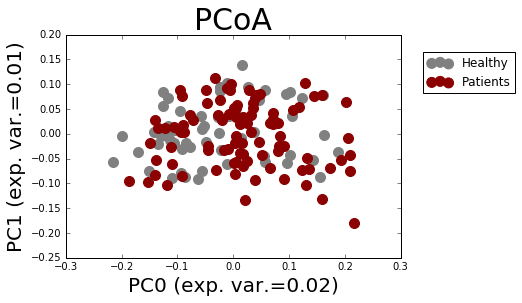

In [26]:
df=sampleByClusterDF_binary_balanced
metric='jaccard'
sample_list_list=[('Healthy',PNP530_balancedAge_males),('Patients',Cardio126_balancedAge_males)]
color_list=['grey','darkred']
pcoa_n1_toplot=0
pcoa_n2_toplot=1
toScale=False,
toAnnotate=False

pcoa_df,fig,ax=calc_PCoA(df,metric,sample_list_list,color_list,pcoa_n1_toplot=0,pcoa_n2_toplot=1,toScale=False,
             toAnnotate=False)

plt.show()

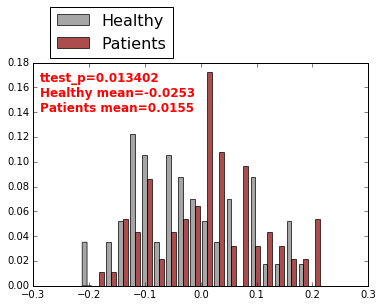

In [27]:
#plot PCoA distributions:
pcoa_n1_toplot=0
sample_list1=PNP530_balancedAge_males
sample_list2=Cardio126_balancedAge_males

dataList=[('Healthy',pcoa_df.loc[sample_list1, pcoa_n1_toplot]),
         ('Patients',pcoa_df.loc[sample_list2, pcoa_n1_toplot])]
fig,ax=plt.subplots()
title=''
colorList=['grey','darkred']
alpha=1
text_kws={'fontsize':'large','fontweight':'bold','color':'red',
                                'horizontalalignment':'left','verticalalignment':'top'}
plotType='hist'



ax,ks_p_cohort1_cohort2,t_p_cohort1_cohort2,p_Anov,filename=plotHistComprison(dataList,ax,title,showLegend=True,nBins=20,toAnnotate=True,
                      colorList=colorList,alpha=alpha,
                      text_kws=text_kws,plotType=plotType)

plt.show()

generating distance matrix...
generating condensed distance matrix using jaccard
top similar pairs:
          dist sample1 sample2
763   0.798177    BD27   BD124
814   0.800100    BD27  BD1083
769   0.813734    BD27   BD106
4510  0.815050   BD124   BD106
4555  0.816545   BD124  BD1083
776   0.819343    BD27   BD150
856   0.819679    BD27   BD984
9136  0.823167  BD1083   BD984
5224  0.824113   BD106  BD1083
5959  0.824178   BD150  BD1083
generating squareform distance matrix using jaccard
calculate PCoA
             0         1         2         3         4         5         6         7         8         9   ...        140       141       142       143       144       145       146       147       148  149
BD801  -0.084166 -0.018515  0.004126 -0.010947  0.052520 -0.004264 -0.032504  0.015681 -0.000561  0.016503 ...   0.052695 -0.020790  0.005890 -0.063313  0.006901 -0.005874 -0.026643  0.028642 -0.005200 -0.0
BD221  -0.119322 -0.001487  0.026497 -0.026498  0.035686 -0.012056 -0.025276  

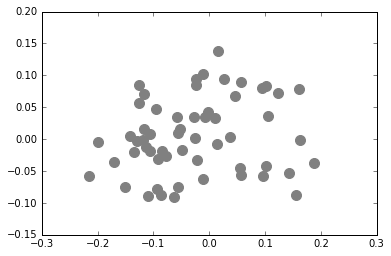

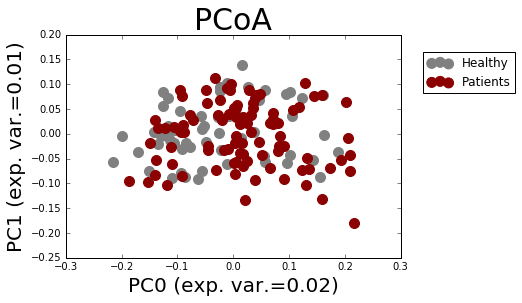

In [23]:
df=sampleByClusterDF_binary_balanced
metric='jaccard'
sample_list_list=[('Healthy',PNP530_balancedAge_males),('Patients',Cardio126_balancedAge_males)]
color_list=['grey','darkred']
pcoa_n1_toplot=0
pcoa_n2_toplot=3
toScale=False,
toAnnotate=False

pcoa_df,fig,ax=calc_PCoA(df,metric,sample_list_list,color_list,pcoa_n1_toplot=0,pcoa_n2_toplot=1,toScale=False,
             toAnnotate=False)

plt.show()

In [ ]:
#plot PCoA distributions:
pcoa_n1_toplot=0
sample_list1=PNP530_balancedAge_males
sample_list2=Cardio126_balancedAge_males

dataList=[('Healthy',pcoa_df.loc[sample_list1, pcoa_n1_toplot]),
         ('Patients',pcoa_df.loc[sample_list2, pcoa_n1_toplot])]
fig,ax=plt.subplots()
title=''
colorList=['grey','darkred']
alpha=1
text_kws={'fontsize':'large','fontweight':'bold','color':'red',
                                'horizontalalignment':'left','verticalalignment':'top'}
plotType='hist'



ax,ks_p_cohort1_cohort2,t_p_cohort1_cohort2,p_Anov,filename=plotHistComprison(dataList,ax,title,showLegend=True,nBins=20,toAnnotate=True,
                      colorList=colorList,alpha=alpha,
                      text_kws=text_kws,plotType=plotType)

plt.show()

generating distance matrix...
generating condensed distance matrix using jaccard
top similar pairs:
          dist sample1 sample2
763   0.798177    BD27   BD124
814   0.800100    BD27  BD1083
769   0.813734    BD27   BD106
4510  0.815050   BD124   BD106
4555  0.816545   BD124  BD1083
776   0.819343    BD27   BD150
856   0.819679    BD27   BD984
9136  0.823167  BD1083   BD984
5224  0.824113   BD106  BD1083
5959  0.824178   BD150  BD1083
generating squareform distance matrix using jaccard
calculate PCoA
             0         1         2         3         4         5         6         7         8         9   ...        140       141       142       143       144       145       146       147       148  149
BD801  -0.084166 -0.018515  0.004126 -0.010947  0.052520 -0.004264 -0.032504  0.015681 -0.000561  0.016503 ...   0.052695 -0.020790  0.005890 -0.063313  0.006901 -0.005874 -0.026643  0.028642 -0.005200 -0.0
BD221  -0.119322 -0.001487  0.026497 -0.026498  0.035686 -0.012056 -0.025276  

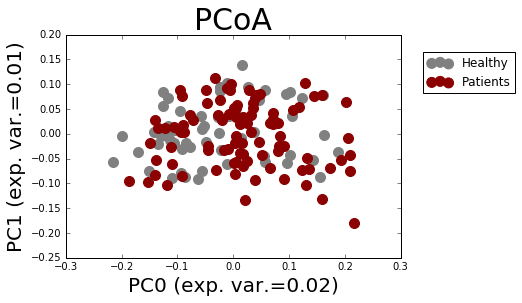

In [24]:
df=sampleByClusterDF_binary_balanced
metric='jaccard'
sample_list_list=[('Healthy',PNP530_balancedAge_males),('Patients',Cardio126_balancedAge_males)]
color_list=['grey','darkred']
pcoa_n1_toplot=0
pcoa_n2_toplot=6
toScale=False,
toAnnotate=False

pcoa_df,fig,ax=calc_PCoA(df,metric,sample_list_list,color_list,pcoa_n1_toplot=0,pcoa_n2_toplot=1,toScale=False,
             toAnnotate=False)

plt.show()

generating distance matrix...
generating condensed distance matrix using dice
top similar pairs:
          dist sample1 sample2
763   0.664138    BD27   BD124
814   0.666806    BD27  BD1083
769   0.685963    BD27   BD106
4510  0.687835   BD124   BD106
4555  0.689968   BD124  BD1083
776   0.693973    BD27   BD150
856   0.694454    BD27   BD984
9136  0.699476  BD1083   BD984
5224  0.700843   BD106  BD1083
5959  0.700938   BD150  BD1083
generating squareform distance matrix using dice
calculate PCoA
             0         1         2         3         4         5         6         7         8         9   ...        140       141       142       143       144       145       146       147       148  149
BD801   0.095376  0.020576  0.002265 -0.039258  0.027317 -0.001880  0.035193  0.014203 -0.006491  0.017041 ...   0.047146 -0.025295  0.022365 -0.051182  0.000669 -0.004018 -0.023524  0.024230 -0.005079  0.0
BD221   0.129115  0.001359 -0.010585 -0.017985  0.041757  0.000319  0.031509 -0.0025

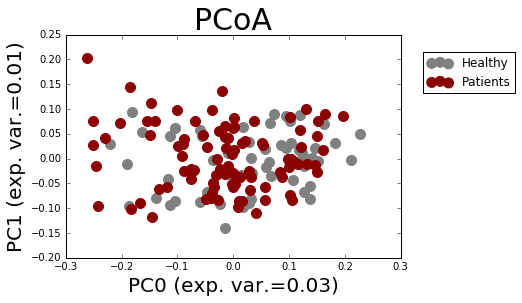

In [25]:
df=sampleByClusterDF_binary_balanced
metric='dice'
sample_list_list=[('Healthy',PNP530_balancedAge_males),('Patients',Cardio126_balancedAge_males)]
color_list=['grey','darkred']
pcoa_n1_toplot=0
pcoa_n2_toplot=1
toScale=False,
toAnnotate=False

pcoa_df,fig,ax=calc_PCoA(df,metric,sample_list_list,color_list,pcoa_n1_toplot=0,pcoa_n2_toplot=1,toScale=False,
             toAnnotate=False)

plt.show()

In [ ]:
#plot PCoA distributions:
pcoa_n1_toplot=0
sample_list1=PNP530_balancedAge_males
sample_list2=Cardio126_balancedAge_males

dataList=[('Healthy',pcoa_df.loc[sample_list1, pcoa_n1_toplot]),
         ('Patients',pcoa_df.loc[sample_list2, pcoa_n1_toplot])]
fig,ax=plt.subplots()
title=''
colorList=['grey','darkred']
alpha=1
text_kws={'fontsize':'large','fontweight':'bold','color':'red',
                                'horizontalalignment':'left','verticalalignment':'top'}
plotType='hist'



ax,ks_p_cohort1_cohort2,t_p_cohort1_cohort2,p_Anov,filename=plotHistComprison(dataList,ax,title,showLegend=True,nBins=20,toAnnotate=True,
                      colorList=colorList,alpha=alpha,
                      text_kws=text_kws,plotType=plotType)

plt.show()

In [ ]:
#plot PCoA distributions:
pcoa_n1_toplot=0
sample_list1=PNP530_balancedAge_males
sample_list2=Cardio126_balancedAge_males

dataList=[('Healthy',pcoa_df.loc[sample_list1, pcoa_n1_toplot]),
         ('Patients',pcoa_df.loc[sample_list2, pcoa_n1_toplot])]
fig,ax=plt.subplots()
title=''
colorList=['grey','darkred']
alpha=1
text_kws={'fontsize':'large','fontweight':'bold','color':'red',
                                'horizontalalignment':'left','verticalalignment':'top'}
plotType='kde'



ax,ks_p_cohort1_cohort2,t_p_cohort1_cohort2,p_Anov,filename=plotHistComprison(dataList,ax,title,showLegend=True,nBins=20,toAnnotate=True,
                      colorList=colorList,alpha=alpha,
                      text_kws=text_kws,plotType=plotType)

plt.show()

In [ ]:
df=sampleByClusterDF_binary_balanced
metric='jaccard'

sample_list1=PNP530_balancedAge_males
sample_list2=Cardio126_balancedAge_males

pcoa_df,fig,ax= calc_PCoA(df,metric,sample_list1,sample_list2,pcoa_n1_toplot=0,pcoa_n2_toplot=3)

## calculate pairwise distance distributions of healthy and patients

### generate distance matrix and annotate pairs:

In [28]:
df=sampleByClusterDF_binary_balanced
metric='jaccard'
print 'generating distance matrix...'
df_condensed_org, distMat_square=genDistMat(df,metric)



generating distance matrix...
generating condensed distance matrix using jaccard
top similar pairs:
          dist sample1 sample2
763   0.798177    BD27   BD124
814   0.800100    BD27  BD1083
769   0.813734    BD27   BD106
4510  0.815050   BD124   BD106
4555  0.816545   BD124  BD1083
776   0.819343    BD27   BD150
856   0.819679    BD27   BD984
9136  0.823167  BD1083   BD984
5224  0.824113   BD106  BD1083
5959  0.824178   BD150  BD1083
generating squareform distance matrix using jaccard


In [39]:
df_condensed_org['sample1_isPatient']=np.where(df_condensed_org['sample1'].isin(Cardio126),1,0)
df_condensed_org['sample2_isPatient']=np.where(df_condensed_org['sample2'].isin(Cardio126),1,0)
df_condensed_org['samples_isPatient_sum']=df_condensed_org[['sample1_isPatient','sample2_isPatient']].sum(axis=1)
df_condensed_org['samples_isPatient_mapped']=df_condensed_org['samples_isPatient_sum'].map({0:'Both healthy',
                                           1:'1 patient',2:'Both patients' })
df_condensed_org[(df_condensed_org['sample1_isPatient']==0)&(df_condensed_org['sample2_isPatient']==1)].head()


,dist,sample1,sample2,sample1_isPatient,sample2_isPatient,samples_isPatient_sum,samples_isPatient_mapped
56,0.962041,BD801,BD1014,0,1,1,1 patient
57,0.928220,BD801,BD1068,0,1,1,1 patient
58,0.905631,BD801,BD1061,0,1,1,1 patient
59,0.898842,BD801,BD996,0,1,1,1 patient
60,0.871957,BD801,BD1053,0,1,1,1 patient


### plot distributions

generating kde plot
generating kde plot
generating kde plot


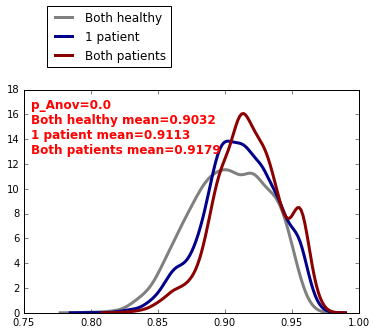

In [50]:
dataList=[('Both healthy',df_condensed_org[df_condensed_org['samples_isPatient_mapped']=='Both healthy']['dist']),
         ('1 patient',df_condensed_org[df_condensed_org['samples_isPatient_mapped']=='1 patient']['dist']),
          ('Both patients',df_condensed_org[df_condensed_org['samples_isPatient_mapped']=='Both patients']['dist'])]
fig,ax=plt.subplots()
title=''
colorList=['grey','darkblue','darkred']
alpha=1
text_kws={'fontsize':'large','fontweight':'bold','color':'red',
                                'horizontalalignment':'left','verticalalignment':'top'}
plotType='kde'



ax,ks_p_cohort1_cohort2,t_p_cohort1_cohort2,p_Anov,filename=plotHistComprison(dataList,ax,title,showLegend=True,nBins=20,toAnnotate=True,
                      colorList=colorList,alpha=alpha,
                      text_kws=text_kws,plotType=plotType)
ax.legend('')
handles,labels=ax.get_legend_handles_labels()
ax.legend('')
ax.legend(handles,labels,bbox_to_anchor=(0.05, 1.4),loc='upper left')
plt.show()

generating kde plot
generating kde plot


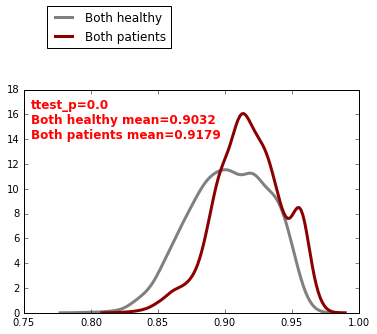

In [51]:
dataList=[('Both healthy',df_condensed_org[df_condensed_org['samples_isPatient_mapped']=='Both healthy']['dist']),
          ('Both patients',df_condensed_org[df_condensed_org['samples_isPatient_mapped']=='Both patients']['dist'])]
fig,ax=plt.subplots()
title=''
colorList=['grey','darkred']
alpha=1
text_kws={'fontsize':'large','fontweight':'bold','color':'red',
                                'horizontalalignment':'left','verticalalignment':'top'}
plotType='kde'



ax,ks_p_cohort1_cohort2,t_p_cohort1_cohort2,p_Anov,filename=plotHistComprison(dataList,ax,title,showLegend=True,nBins=20,toAnnotate=False,
                      colorList=colorList,alpha=alpha,
                      text_kws=text_kws,plotType=plotType)
ax.text 
plt.show()

# balanced group clustering:

In [ ]:
def filter_matrix_by_sharing_perc(matrix, sample_list1,sample_list2,percShared=0.1,percTooMany=0.9):
    # ##generate cluster list:
    
    # get clusters that appear in Xperc or nShared of samples in sample_list1:
    print ('perc Shared is ', percShared)
    matrix_group1 = matrix.loc[sample_list1, :]
    nShared_group1 = math.ceil(len(matrix_group1) * percShared)

    print ('nShared_group1= ', nShared_group1)
    group1_percClusters = matrix_group1.loc[:, matrix_group1.count() >= nShared_group1].columns.tolist()
    print ('n clusters shared by %s or more samples in group1= ' % nShared_group1, len(group1_percClusters))
    
    # get clusters that appear in Xperc of samples in sample_list2:
    matrix_group2 = matrix.loc[sample_list2, :]
    nShared_group2 = math.ceil(len(matrix_group2) * percShared)
    print ('nShared_group2= ', nShared_group2)
    group2_percClusters = matrix_group2.loc[:, matrix_group2.count() >= nShared_group2].columns.tolist()
    print ('n clusters shared by %s or more samples in group2= ' % nShared_group2, len(group2_percClusters))
    
   
    
    # concatenate lists:
    ClusterListShared = list(set(group1_percClusters + group2_percClusters))
    print ('total number of clusters shared by more than %s ' % percShared, len(ClusterListShared))
    
    # filter table to have only those sequences
    matrix_perc = matrix.loc[:, ClusterListShared]
    # filter table to not include clusters that appear in more than percTooMany of samples:
    nTooMany = math.ceil(len(matrix) * percTooMany)
    print 'filtering out clusters that appear in more than %s (%s) samples' % (nTooMany, percTooMany)
    matrix_perc = matrix_perc.loc[:, matrix_perc.count() < nTooMany]
    print ('final matrix_perc shape is: ', matrix_perc.shape)
                             
                             
    return matrix

In [ ]:
#get cluster binary matrix
sampleByClusterDF=pd.read_pickle('/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/\
sharingAnalysis/seqClusters_allProd_maxdist1/sampleByClusterDF_cohortfiltering005-085perc_dropped.dat')

sampleByClusterDF_binary=(sampleByClusterDF>0).astype(int)

In [ ]:
# get samples lists:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530_balancedAge_males') as fp:
    PNP530_balancedAge_males=pickle.load(fp)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126_balancedAge_males') as fp:
    Cardio126_balancedAge_males=pickle.load(fp)

In [ ]:
sampleByClusterDF_binary_balanced=sampleByClusterDF_binary.loc[PNP530_balancedAge_males+Cardio126_balancedAge_males,:].replace(0,np.nan)
print sampleByClusterDF_binary_balanced.shape
sampleByClusterDF_binary_balanced.iloc[:5,:5]

In [ ]:
sampleByClusterDF_balanced=sampleByClusterDF.loc[PNP530_balancedAge_males+Cardio126_balancedAge_males,:].replace(0,np.nan)
print sampleByClusterDF_binary_balanced.shape
print sampleByClusterDF_balanced.shape
sampleByClusterDF_balanced.iloc[:5,:5]

In [ ]:
matrix=sampleByClusterDF_binary_balanced
sample_list1=PNP530_balancedAge_males
sample_list2=Cardio126_balancedAge_males

#get iscardio
PRED_RESULTS_DIR='/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/'
isCardio=pd.read_pickle(PRED_RESULTS_DIR+'TargetDFs/isCardio.dat')

#extract only sequences shared by x percent in one of the groups:
matrix_025_085=filter_matrix_by_sharing_perc(matrix, sample_list1,sample_list2,percShared=0.25,percTooMany=0.85)

#clustermap

In [ ]:
matrix=sampleByClusterDF_binary_balanced
sample_list1=PNP530_balancedAge_males
sample_list2=Cardio126_balancedAge_males

#get iscardio
PRED_RESULTS_DIR='/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/'
isCardio=pd.read_pickle(PRED_RESULTS_DIR+'TargetDFs/isCardio.dat')

#extract only sequences shared by x percent in one of the groups:
matrix_08_085=filter_matrix_by_sharing_perc(matrix, sample_list1,sample_list2,percShared=0.8,percTooMany=0.85)

#clustermap

In [ ]:
matrix_06_085_dc = matrix_06_085.apply(pd.to_numeric,downcast='float')

In [ ]:
matrix_06_085_dc.iloc[:5,:5]

In [ ]:
#plot clustermap:
g = sns.clustermap(matrix_08_085, method='average', metric='jaccard', figsize=None,
                   cbar_kws=None, row_cluster=True, col_cluster=True, row_linkage=None,
                   col_linkage=None, row_colors=None, col_colors=None, mask=None)
plt.show()

In [ ]:
#get cluster binary matrix
matrix=sampleByClusterDF_binary_balanced
sample_list1=PNP530_balancedAge_males
sample_list2=Cardio126_balancedAge_males

#get iscardio
PRED_RESULTS_DIR='/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/'
isCardio=pd.read_pickle(PRED_RESULTS_DIR+'TargetDFs/isCardio.dat')

#extract only sequences shared by x percent in one of the groups:
matrix_01_09=filter_matrix_by_sharing_perc(matrix, sample_list1,sample_list2,percShared=0.1,percTooMany=0.9)

#clustermap

# old stuff:

## function from Noam:

In [ ]:
!pip install tqdm

In [ ]:
def PCoA_analysis(base_data, rest_data, save2path=None, distance_method='BrayCurtis', do_binary=False):
    
    from datetime import datetime
    from skbio.stats.ordination._principal_coordinate_analysis import PCoA
    from scipy.spatial.distance import braycurtis, pdist, squareform, euclidean, cdist,jaccard
    
    print ("PCoA_analysis", str(datetime.now()))
    # add check for distance method
    distance_dict = {'BrayCurtis':braycurtis, 'Euclidean':pdist,'jaccard':jaccard}
    if distance_method not in distance_dict:
        print ("distance_method must be one of: " + ", ".join(distance_method.keys()))
        return
    # concat dataframes
    joined_data = pd.concat((base_data, rest_data), axis=1).dropna(how='all').fillna(0)
    # compute distance matries
    print ("Computing " + distance_method + " distances between samples. For datasets with many elements this will take a while.")
    dis_mat = compute_distance_matrix(joined_data, distance_meausere=BrayCurtis, do_binary=do_binary, transpose=False)
    temp_dis = DistanceMatrix(dis_mat.values, dis_mat.index)
    pcoa = PCoA(temp_dis)
    pcoa_df = pd.DataFrame(pcoa.scores().site, index=temp_dis.ids, columns=range(pcoa.scores().site.shape[1]))

    plt.figure(figsize=(12,8))
    plt.scatter(pcoa_df.loc[base_data.columns, 0], pcoa_df.loc[base_data.columns, 1], color='blue', alpha=0.5, s=50, label='base')
    plt.scatter(pcoa_df.loc[rest_data.columns, 0], pcoa_df.loc[rest_data.columns, 1], color='red', alpha=0.5, s=50, label='rest')
    plt.title('PCoA', fontsize=30)
    plt.xlabel('PC1 - %0.2f' % pcoa.scores().proportion_explained[0], fontsize=20)
    plt.ylabel('PC2 - %0.2f' % pcoa.scores().proportion_explained[1], fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc='upper right', fontsize=20)
    if save2path is not None:
        plt.savefig(save2path + 'PCoA_pc1-pc2.png', bbox_inches='tight')
    plt.show()

    mw_p = []
    for i in range(10):
        mw_p.append(directed_mannwhitneyu(pcoa_df.loc[base_data.columns, i], pcoa_df.loc[rest_data.columns, i])[1])
    mw_p= -np.log10(np.array(mw_p))
    plt.plot(range(1,11), mw_p, 'o',  range(1,11), mw_p, 'k')
    plt.xlabel('PC', fontsize=15)
    plt.ylabel('Mann-Whitney p-value [-log10]', fontsize=15)
    plt.title('PCoA - Association of PC to dataset', fontsize=20)
    if save2path is not None:
        plt.savefig(save2path + 'mann_whitney-pc.png', bbox_inches='tight')
    plt.show()
    return

In [ ]:
def compute_distance_matrix(samps_by_features, distance_meausere, do_binary = False, 
                            check_for_na=False, transpose=True):
    if transpose:
        A = samps_by_features.T.copy()
    else:
        A = samps_by_features.copy()
    temp_res = pd.DataFrame(1, index=A.columns, columns=A.columns, dtype=np.float64)
    A = A.values
    if do_binary:
        A[A>0] = 1
  
#     quants = A.shape[1] / 10
        
    for i in tnrange(A.shape[1], desc='distance matrix computation'):
        a = A[:,i]
        vals = []
#         if i % quants == 0:
#             print (str(10 * i/quants) + '%')
        for j in range(A.shape[1]):
            b = A[:,j]
            val = None
            if check_for_na:
                c = ~np.isnan(a) & ~np.isnan(b)
                val = distance_meausere(np.stack((a[c],b[c]),axis=1).T)
            else:
                val = distance_meausere(np.stack((a,b),axis=1).T)
            vals.append(val)
        temp_res.iloc[i,:] = vals
    return temp_res

In [ ]:
base_data=sampleByClusterDF.loc[PNP530,:]
rest_data=sampleByClusterDF.loc[Cardio126,:]



In [ ]:
PCoA_analysis(base_data, rest_data, save2path=None, distance_method='Euclidean', do_binary=False)